In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
from scipy import stats
import theano
import pandas as pd

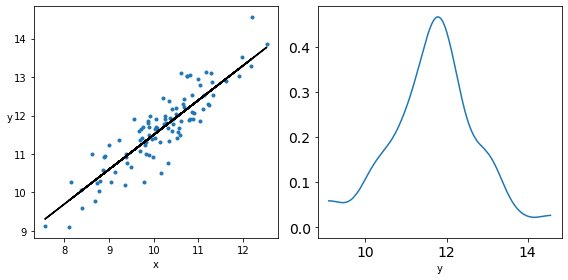

In [2]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size = N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

y = y_real + eps_real

_, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation = 0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax = ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [3]:
# not a good model..
with pm.Model() as model_g:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_g = pm.sample(2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8905241519081083, but should be close to 0.8. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5926165297649649, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

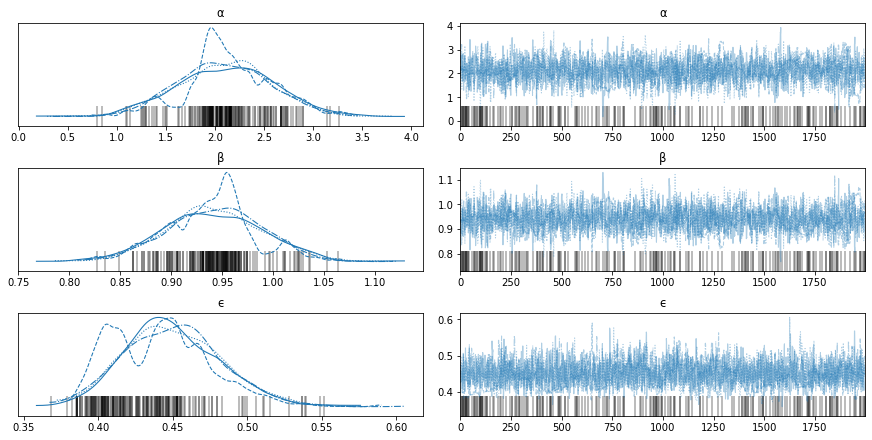

In [4]:
az.plot_trace(trace_g, var_names = ['α', 'β', 'ϵ'])

# Linear models and high autocorrelation

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot:xlabel='α', ylabel='β'>

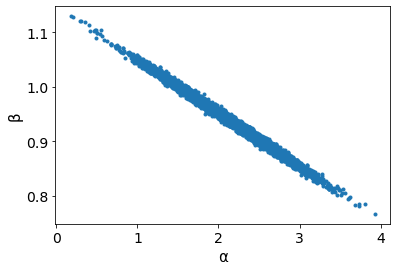

In [5]:
az.plot_pair(trace_g, var_names = ['α', 'β'], plot_kwargs = {'alpha': 0.1})

# Centering & Scaling

Good for two reasons: 
1. good for algorithms (fit better/faster). 
2. good for interpretation (e.g. intercept - for centering, Z-scores - for scaling)

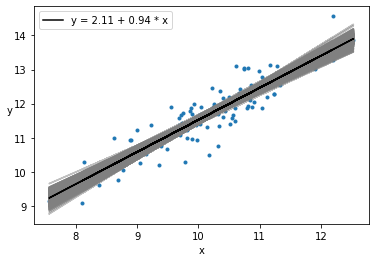

In [6]:
# fitted draws I think (so not predictive posterior, without the uncertainty).
# i.e. uncertainty around population value rather than individual obs. 
plt.plot(x, y, 'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

draws = range(0, len(trace_g['α']), 10)

plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws] * x[:, np.newaxis], c = 'gray', alpha = 0.5)

plt.plot(x, alpha_m + beta_m * x, c = 'k', label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation = 0)
plt.legend()

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


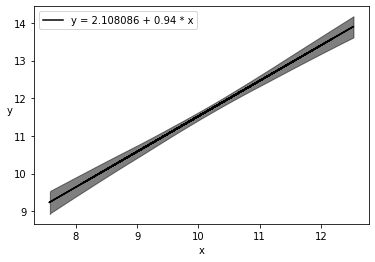

In [7]:
# HPD
plt.plot(x, alpha_m + beta_m * x, c = 'k',
        label = f'y = {alpha_m:2f} + {beta_m:.2f} * x')

sig = az.plot_hpd(x, trace_g['μ'], credible_interval = .98, color = 'k')
plt.xlabel('x')
plt.ylabel('y', rotation = 0)
plt.legend()

In [8]:
# posterior predictive samples
ppc = pm.sample_posterior_predictive(trace_g,
                                    samples = 2000,
                                    model = model_g)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


Text(0, 0.5, 'y')

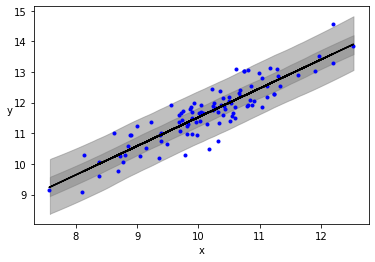

In [9]:
# plot the result
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c = 'k',
        label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(x, ppc['y_pred'], credible_interval = 0.5, color = 'gray')
az.plot_hpd(x, ppc['y_pred'], color = 'gray') #method = lm as baseline, but can do smooth.

plt.xlabel('x')
plt.ylabel('y', rotation = 0)

# Pearson correlation coefficient, R^2, etc.

In [10]:
az.r2_score(y, ppc['y_pred'])

r2        0.787716
r2_std    0.006202
dtype: float64

# Bivariate Gaussians

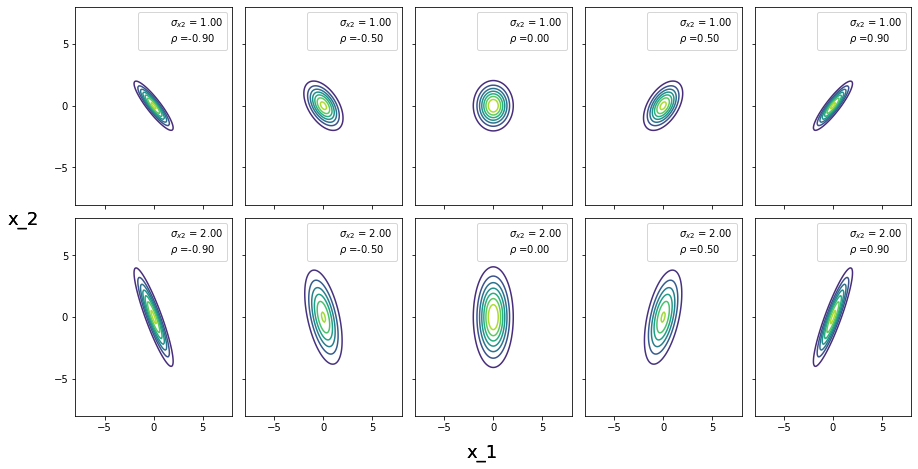

In [11]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.9, -0.5, 0, 0.5, 0.9]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), 
                    sharex = True, sharey = True, 
                    figsize = (12, 6), 
                    constrained_layout = True)

for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
              [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0, label = f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ ={rho:3.2f}', 
                      alpha = 0)
        ax[i, j].legend()
    f.text(0.5, -0.05, 'x_1', ha = 'center', fontsize = 18)
    f.text(-0.05, 0.5, 'x_2', va = 'center', fontsize = 18, rotation = 0)

In [12]:
data = np.stack((x, y)).T

with pm.Model() as pearson_model:
    
    μ = pm.Normal('μ', mu = data.mean(0), sd = 10, shape = 2)
    
    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    pearson = pm.Uniform('pearson', -1., 1.)
    r2 = pm.Deterministic('r2', pearson**2)
    
    cov = pm.math.stack(([σ_1 ** 2, σ_1 * σ_2 * pearson],
                        [σ_1 * σ_2 * pearson, σ_2 ** 2]))
    
    y_pred = pm.MvNormal('y_pred', mu = μ, cov = cov, observed = data)
    
    trace_p = pm.sample(1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pearson, σ_2, σ_1, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


array([[<AxesSubplot:title={'center':'r2'}>,
        <AxesSubplot:title={'center':'r2'}>]], dtype=object)

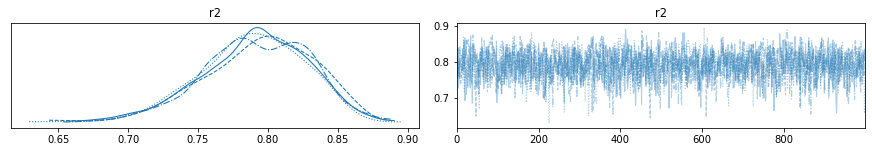

In [13]:
az.plot_trace(trace_p, var_names = ['r2'])

In [14]:
az.summary(trace_p, var_names = ['r2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
r2,0.791,0.039,0.72,0.862,0.001,0.001,1592.0,1582.0,1547.0,1893.0,1.0


# Robust linaer regression

In [15]:
import pandas as pd
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean() #centering. 

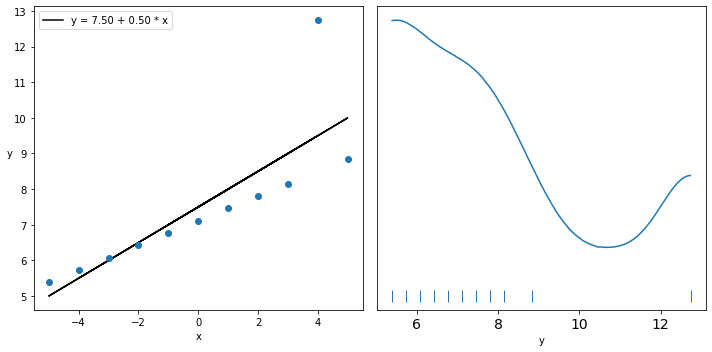

In [16]:
_, ax = plt.subplots(1, 2, figsize = (10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
          label = f'y = {alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation = 0)
ax[0].legend(loc = 0)
az.plot_kde(y_3, ax = ax[1], rug = True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

In [17]:
# not a good model..
with pm.Model() as model_t:
    α = pm.Normal('α', mu = y_3.mean(), sd = 10)
    β = pm.Normal('β', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    v_ = pm.Exponential('v_', 1/29)
    v = pm.Deterministic('v', v_ + 1) #shifted. 
    
    y_pred = pm.StudentT('y_pred', mu = α + β * x_3, sd = ϵ, nu = v, observed = y_3)
    
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


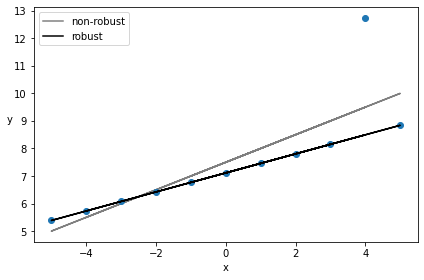

In [18]:
# robust (model t vs. non-rubust, linregress). 
# this is very nice. 
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k',
        label = 'non-robust', alpha = 0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c = 'k', label = 'robust')

plt.xlabel('x')
plt.ylabel('y', rotation = 0)
plt.legend(loc = 2)
plt.tight_layout()

In [19]:
az.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.111,7.117,0.000,0.000,4398.0,4398.0,4685.0,3940.0,1.0
β,0.345,0.000,0.345,0.346,0.000,0.000,3805.0,3802.0,3931.0,3338.0,1.0
ϵ,0.003,0.002,0.001,0.006,0.000,0.000,2345.0,2345.0,1292.0,754.0,1.0
v_,0.211,0.202,0.000,0.578,0.003,0.002,6089.0,6089.0,3446.0,2121.0,1.0
v,1.211,0.202,1.000,1.578,0.003,0.002,6089.0,6089.0,3446.0,2121.0,1.0


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(0.0, 12.0)

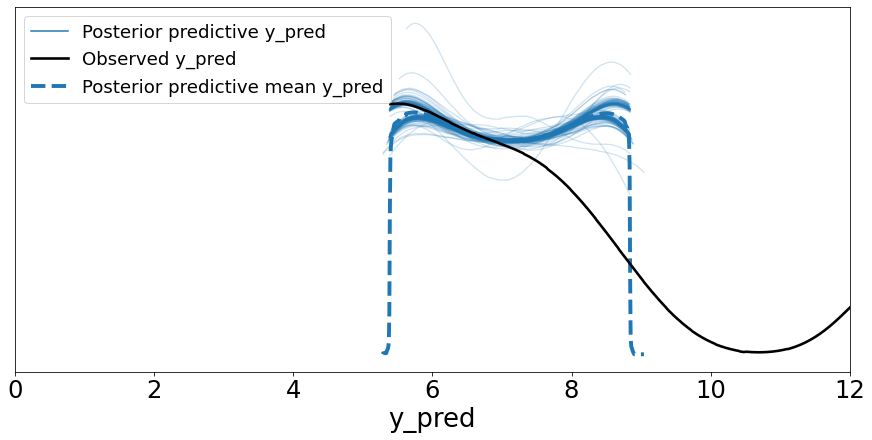

In [20]:
ppc = pm.sample_posterior_predictive(trace_t,
                                     samples = 200,
                                     model = model_t,
                                     random_seed = 2)

data_ppc = az.from_pymc3(trace = trace_t, posterior_predictive = ppc)
ax = az.plot_ppc(data_ppc, figsize = (12, 6), mean = True)
plt.xlim(0, 12)

# Hierarchical linear regression

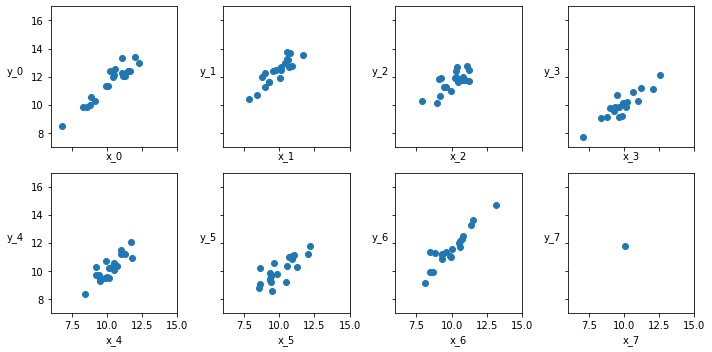

In [21]:
N = 20
M = 8
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size = M)
beta_real = np.random.beta(6, 1, size = M)
eps_real = np.random.normal(0, 0.5, size = len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize = (10, 5), sharex = True,
                    sharey = True)
ax = np.ravel(ax)
j, k = 0, N

for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation = 0, labelpad = 15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N

plt.tight_layout()

In [22]:
# center the data
x_cent = x_m - x_m.mean()

In [23]:
# first non-hierarchical
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu = 0, sd = 10, shape = M)
    β = pm.Normal('β', mu = 0, sd = 10, shape = M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    v = pm.Exponential('v', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu = α_tmp[idx] + β[idx] * x_cent,
                        sd = ϵ, nu = v, observed = y_m)
    
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    
    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

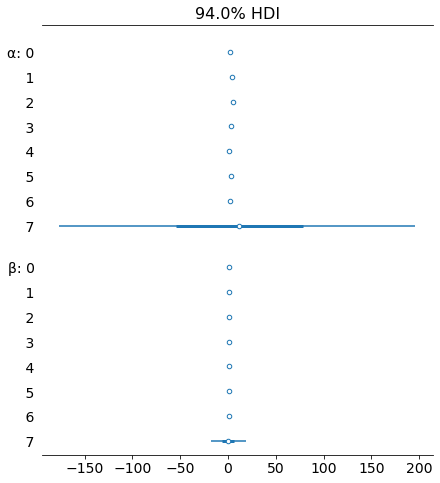

In [24]:
az.plot_forest(trace_up, var_names = ['α', 'β'], combined = True)

In [36]:
with pm.Model() as hierarchical_model:
    
    # hypers 
    α_μ_tmp = pm.Normal('α_μ_tmp', mu = 0, sd = 10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sd = 10)
    β_μ = pm.Normal('β_μ', mu = 0, sd = 10)
    β_σ = pm.HalfNormal('β_σ', sd = 10)
    
    
    # priors
    α_tmp = pm.Normal('α_tmp', mu = α_μ_tmp, sd = α_σ_tmp, shape = M) #number of datapoints in each.
    β = pm.Normal('β', mu = β_μ, sd = β_σ, shape = M)
    ϵ = pm.HalfCauchy('ϵ', beta = 5)
    v = pm.Exponential('v', 1/30)
    
    y_pred = pm.StudentT('y_pred',
                        mu = α_tmp[idx] + β[idx] * x_cent,
                         sd = ϵ, nu = v, observed = y_m)
    
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())
    
    # trace
    trace_hm = pm.sample(1000) #errors.
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

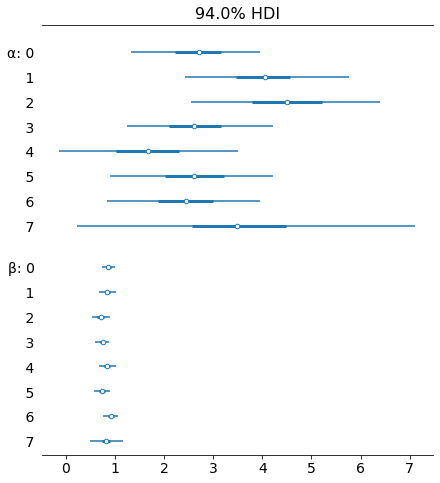

In [37]:
az.plot_forest(trace_hm, var_names = ['α', 'β'], combined = True) 

In [38]:
# both unpooled & pooled in same plot

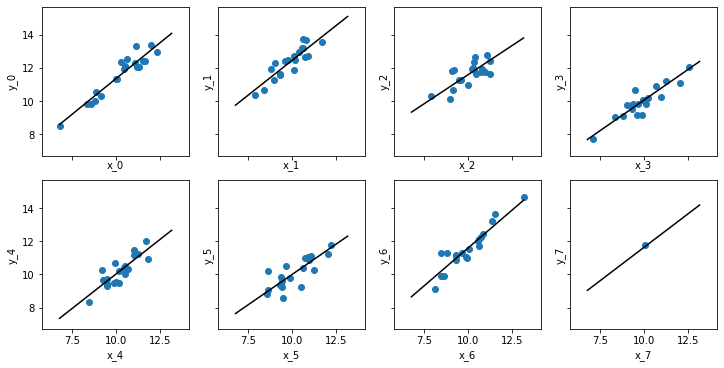

In [39]:
# show fit line to one point.
_, ax = plt.subplots(2, 4, figsize = (10, 5), 
                    sharex = True, sharey = True,
                    constrained_layout = True)

ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10) #from, to, length.out I think. 
for i in range(M): 
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}')
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c = 'k',
              label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min() - 1, x_m.max() + 1)
    plt.ylim(y_m.min() - 1, y_m.max() + 1)
    j += N
    k += N

# Polynomial regression

Text(0, 0.5, 'y')

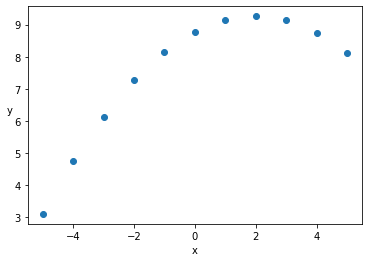

In [41]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation = 0)

In [42]:
?pm.Deterministic

In [46]:
with pm.Model() as model_poly: 
    
    α = pm.Normal('α', mu = y_2.mean(), sd = 1)
    β1 = pm.Normal('β1', mu = 0, sd = 1)
    β2 = pm.Normal('β2', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + β1 * x_2 + β2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y_2)
    
    # trace
    trace_poly = pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


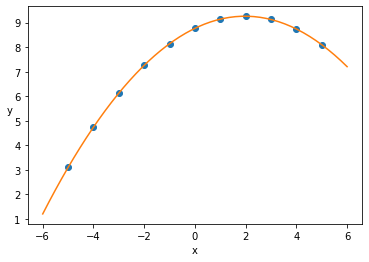

In [49]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation = 0)
plt.plot(x_p, y_p, c = 'C1')

# 

Text(0, 0.5, 'y')

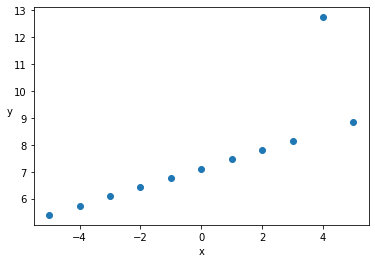

In [50]:
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

plt.scatter(x_3, y_3)
plt.xlabel('x')
plt.ylabel('y', rotation = 0)

In [56]:
with pm.Model() as quad_three:
    
    α = pm.Normal('α', mu = y_3.mean(), sd = 1)
    β1 = pm.Normal('β1', mu = 0, sd = 1)
    β2 = pm.Normal('β2', mu = 0, sd = 1)
    β3 = pm.Normal('β3', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + β1 * x_3 + β2 * x_3**2 + β3 * x_3**3
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = x_3)
    
    # samples
    quad_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β3, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


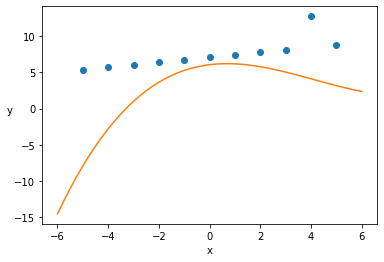

In [58]:
x_p = np.linspace(-6, 6)
y_p = quad_trace['α'].mean() + quad_trace['β1'].mean() * x_p + quad_trace['β2'].mean() * x_p**2 + quad_trace['β3'].mean() * x_p**3
plt.scatter(x_3, y_3)
plt.xlabel('x')
plt.ylabel('y', rotation = 0)
plt.plot(x_p, y_p, c = 'C1')

# Multiple (linear) regression

In [59]:
# data
np.random.seed(314)
N = 100
alpha_real  = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size = N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis = 0, keepdims = True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [60]:
def scatter_plot(x, y):
    plt.figure(figsize = (10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx + 1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation = 0)
    
    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation = 0)

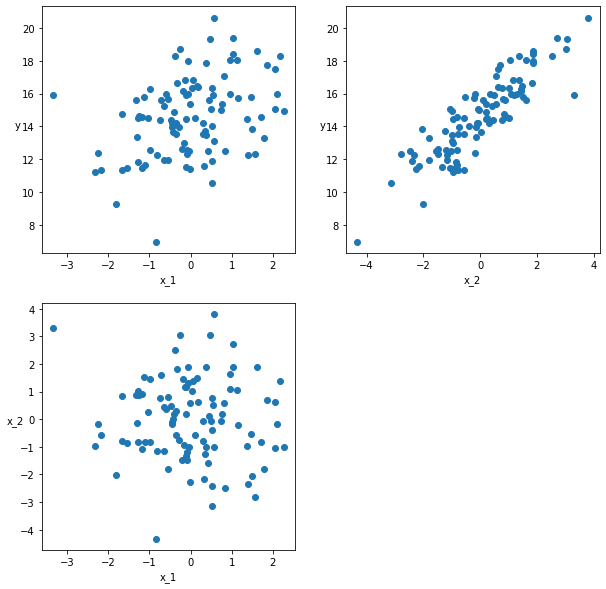

In [61]:
scatter_plot(X_centered, y)

In [62]:
# model
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 1, shape = 2) #2 predictors
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α_tmp + pm.math.dot(X_centered, β)
    
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


In [63]:
varnames = ['α', 'β', 'ϵ']
az.summary(trace_mlr, var_names = varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],1.854,0.463,0.985,2.717,0.004,0.003,12517.0,11138.0,12547.0,5761.0,1.0
β[0],0.969,0.045,0.881,1.049,0.000,0.000,12603.0,12603.0,12652.0,5940.0,1.0
β[1],1.469,0.033,1.407,1.532,0.000,0.000,11894.0,11879.0,11894.0,6091.0,1.0
ϵ,0.474,0.035,0.410,0.540,0.000,0.000,11441.0,11216.0,11564.0,6387.0,1.0


In [64]:
# generate data
np.random.seed(42)
N = 100
x_1 = np.random.normal(size = N)
x_2 = x_1 + np.random.normal(size = N, scale = 1)
y = x_1 + np.random.normal(size = N)
X = np.vstack((x_1, x_2)).T

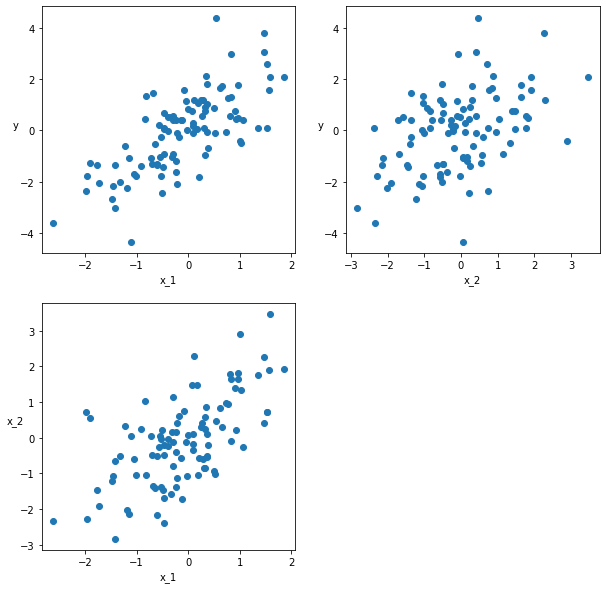

In [65]:
scatter_plot(X, y)

In [66]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu = 0, sd = 10)
    β1 = pm.Normal('β1', mu = 0, sd = 10)
    β2 = pm.Normal('β2', mu = 0, sd = 10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_x1x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


In [73]:
with pm.Model() as m_x1:
    α = pm.Normal('α', mu = 0, sd = 10)
    β1 = pm.Normal('β1', mu = 0, sd = 10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + β1 * X[:, 0] 
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_x1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


In [74]:
with pm.Model() as m_x2:
    α = pm.Normal('α', mu = 0, sd = 10)
    β2 = pm.Normal('β2', mu = 0, sd = 10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + β2 * X[:, 1] 
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

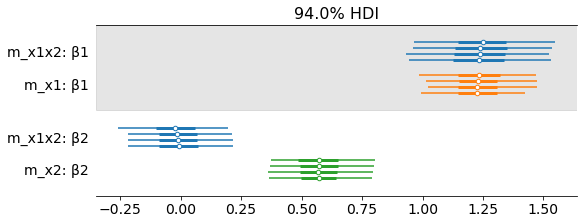

In [75]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
              model_names = ['m_x1x2', 'm_x1', 'm_x2'],
              var_names = ['β1', 'β2'],
              combined = False, colors = 'cycle', figsize = (8, 3))

# Multicollinearity (too high)

In [76]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size = N)
x_2 = x_1 + np.random.normal(size = N, scale = 0.01)
y = x_1 + np.random.normal(size = N)
X = np.vstack((x_1, x_2)).T

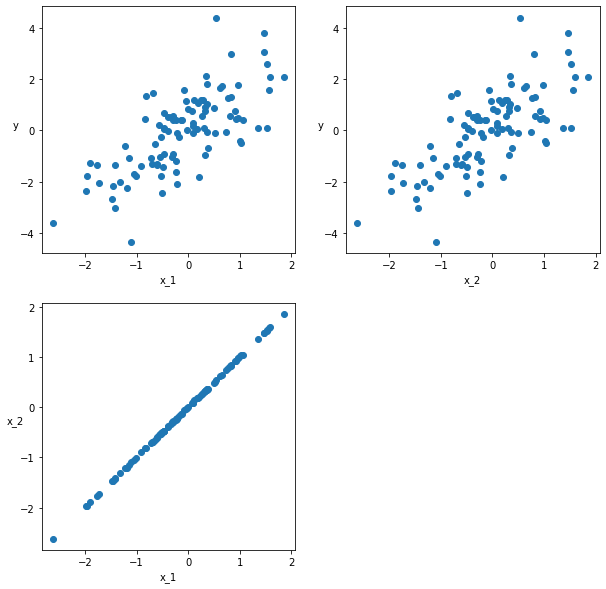

In [77]:
scatter_plot(X, y)

In [81]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 10, shape = 2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + pm.math.dot(X, β)
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_red = pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 102 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

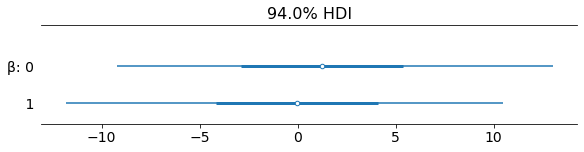

In [83]:
az.plot_forest(trace_red, var_names = ['β'],
              combined = True, figsize = (8, 2))

<AxesSubplot:xlabel='β\n0', ylabel='β\n1'>

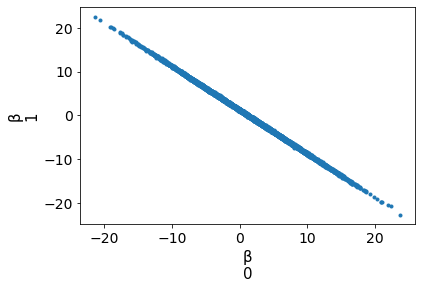

In [84]:
# HPD
az.plot_pair(trace_red, var_names = ['β'])

# Masking effect variables

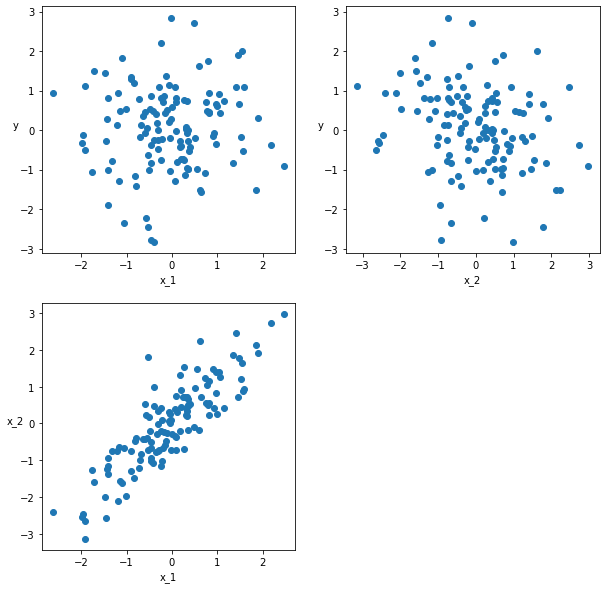

In [86]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size = N)
x_2 = np.random.normal(x_1, scale = (1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T
scatter_plot(X, y)

In [90]:
# model 1
with pm.Model() as m_x1x2:
    
    α = pm.Normal('α', mu = 0, sd = 10)
    β1 = pm.Normal('β1', mu = 0, sd = 10) #two predictors
    β2 = pm.Normal('β2', mu = 0, sd = 10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    # trace
    trace_x1x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
The acceptance probability does not match the target. It is 0.8841500060612099, but should be close to 0.8. Try to increase the number of tuning steps.


In [93]:
# model 2
with pm.Model() as m_x1:
    
    α = pm.Normal('α', mu = 0, sd = 10)
    β1 = pm.Normal('β1', mu = 0, sd = 10) #two predictors
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + β1 * X[:, 0]
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    # trace
    trace_x1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [94]:
# model 3
with pm.Model() as m_x2:
    
    α = pm.Normal('α', mu = 0, sd = 10)
    β2 = pm.Normal('β2', mu = 0, sd = 10) #two predictors
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = α + β2 * X[:, 1]
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    # trace
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

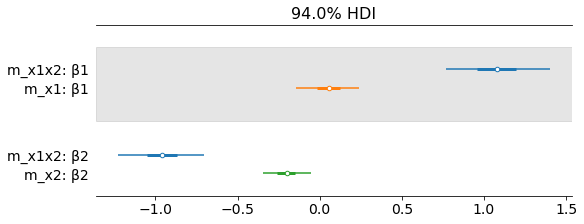

In [95]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
              model_names = ['m_x1x2', 'm_x1', 'm_x2'],
              var_names = ['β1', 'β2'],
              combined = True, colors = 'cycle', figsize = (8, 3))

# Interactions

<AxesSubplot:xlabel='Month', ylabel='Lenght'>

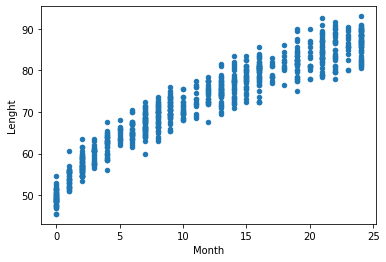

In [129]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')

In [135]:
import theano

In [136]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd = 10)
    β = pm.Normal('β', sd = 10)
    γ = pm.HalfNormal('γ', sd = 10)
    δ = pm.HalfNormal('δ', sd = 10)
    
    x_shared = theano.shared(data.Month.values * 1.) #theano tensor.
    
    μ = pm.Deterministic('μ', α + β * x_shared ** 0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)
    
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = data.Lenght)
    
    trace_vv = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, γ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Text(0, 0.5, 'y')

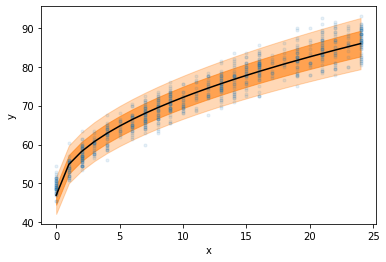

In [137]:
# plot of estimate w. bands for [1, 2] SD. 
plt.plot(data.Month, data.Lenght, 'C0.', alpha = 0.1)

μ_m = trace_vv['μ'].mean(0)
ϵ_m = trace_vv['ϵ'].mean(0)

plt.plot(data.Month, μ_m, c = 'k')
plt.fill_between(data.Month, μ_m + 1 * ϵ_m, μ_m - 1 * ϵ_m, alpha = 0.6, color = 'C1')
plt.fill_between(data.Month, μ_m + 2 * ϵ_m, μ_m - 2 * ϵ_m, alpha = 0.3, color = 'C1')

plt.xlabel('x')
plt.ylabel('y')

In [138]:
# getting an unobserved value (0.5)
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model = model_vv)
y_ppc = ppc['y_pred'][:, 0]

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


TypeError: cannot unpack non-iterable AxesSubplot object

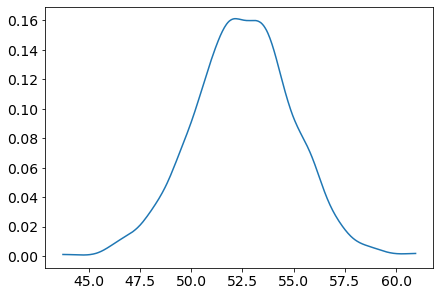

In [153]:
# deprecated function, need to fix somehow. 
ref = 47.5
density, l, u = az.plot_kde(y_ppc) #not optimal
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                label = 'percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()

# Exercise 6

In [155]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size = N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

y = y_real + eps_real

In [171]:
# baseline (NUTS)
with pm.Model() as model_g:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_g = pm.sample(2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


In [172]:
# metropolis
with pm.Model() as model_gm:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_gm = pm.sample(2000, tune = 1000, step = [pm.Metropolis()]) #??

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>]], dtype=object)

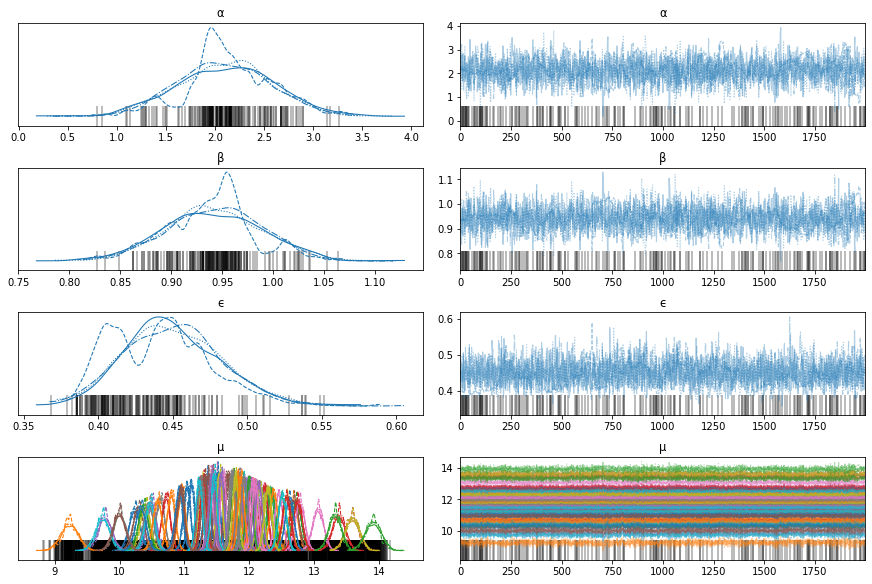

In [167]:
az.plot_trace(trace_g) #sort of works.

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>]], dtype=object)

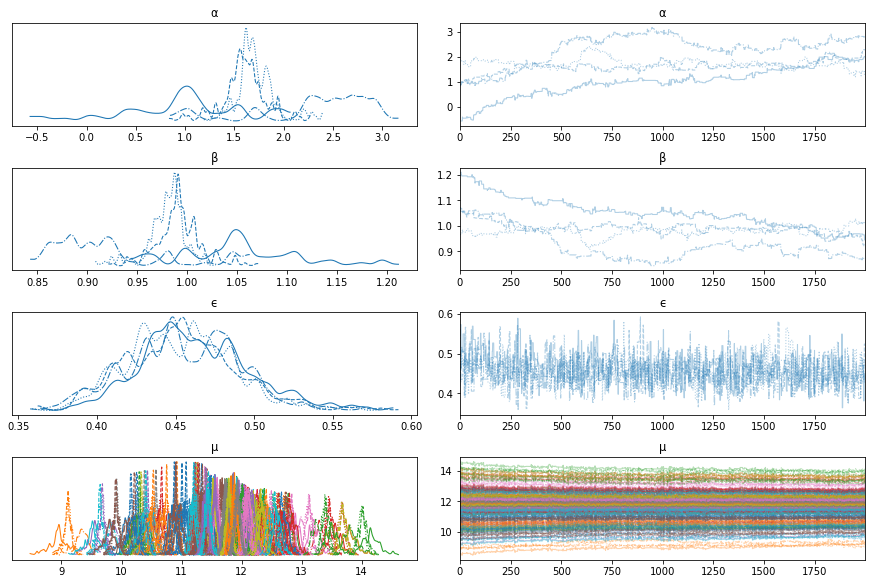

In [168]:
az.plot_trace(trace_gm) #does not converge.

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot:xlabel='α', ylabel='β'>

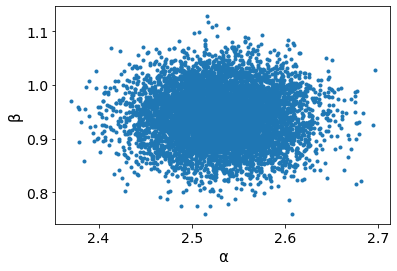

In [173]:
az.plot_pair(trace_g, var_names = ['α', 'β'], plot_kwargs = {'alpha': 0.1})

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot:xlabel='α', ylabel='β'>

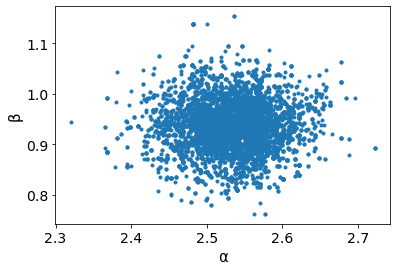

In [174]:
az.plot_pair(trace_gm, var_names = ['α', 'β'], plot_kwargs = {'alpha': 0.1})

In [175]:
# centering
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size = N)

x = np.random.normal(10, 1, N)
x = x - x.mean() #centering. 
y_real = alpha_real + beta_real * x

y = y_real + eps_real

In [176]:
# baseline (NUTS) centered. 
with pm.Model() as model_gc:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_gc = pm.sample(2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


In [177]:
# metropolis centered
with pm.Model() as model_gmc:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    trace_gmc = pm.sample(2000, tune = 1000, step = [pm.Metropolis()]) #??

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>]], dtype=object)

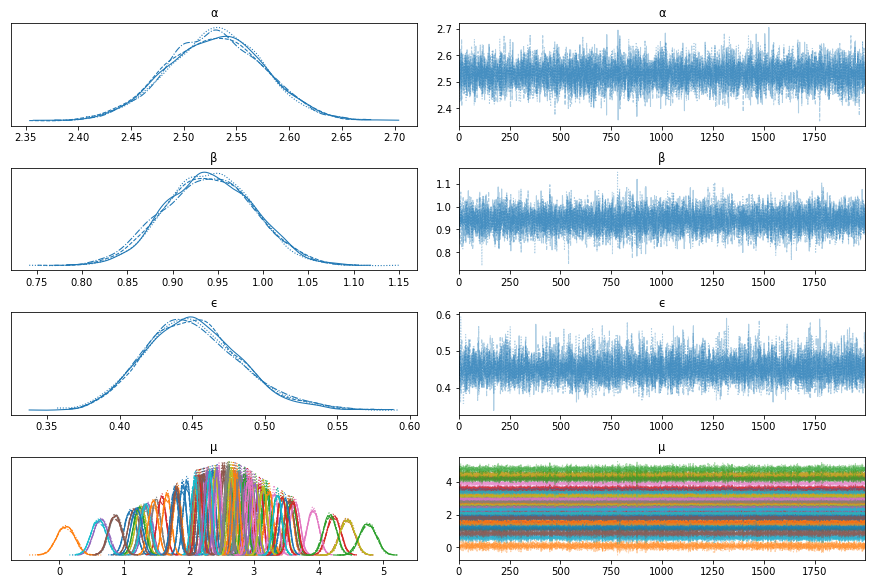

In [179]:
az.plot_trace(trace_gc) #also helps here actually it seems. 

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>]], dtype=object)

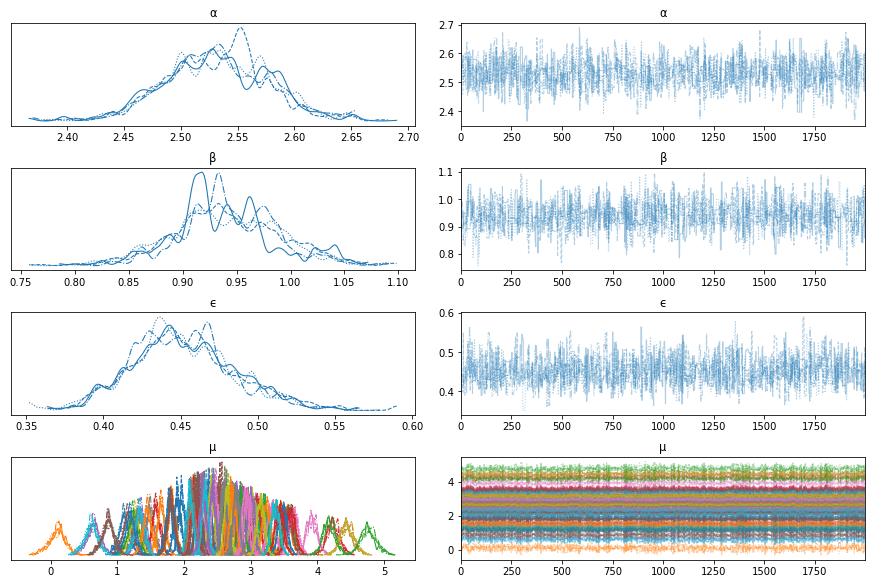

In [180]:
az.plot_trace(trace_gmc) # still worse, but much better. 

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot:xlabel='α', ylabel='β'>

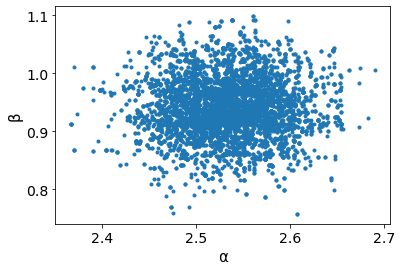

In [181]:
az.plot_pair(trace_gmc, var_names = ['α', 'β'], plot_kwargs = {'alpha': 0.1})

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot:xlabel='α', ylabel='β'>

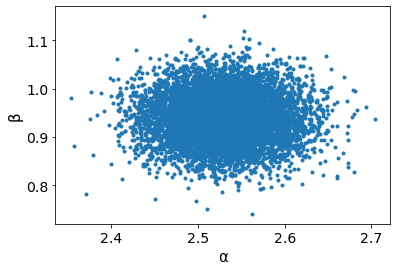

In [182]:
az.plot_pair(trace_gc, var_names = ['α', 'β'], plot_kwargs = {'alpha': 0.1})

In [183]:
# seems that centering really helps metropolis (but also nuts). 
# nuts generally seems much stronger (better convergence).
# not really sure about the plot_pairs thing..?

# Exercise 7

In [12]:
# read data
howell = pd.read_csv('../data/howell.csv', sep = ";")
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [13]:
# exclude younger than 18
h_sub = howell[howell['age'] > 18]

In [14]:
# take out the values
y = h_sub['height'].values
x = h_sub['weight'].values

In [15]:
# center x so that intercept is meaningful. 
x_norm = x - x.mean()

In [16]:
# model
with pm.Model() as h:
    
    # priors
    α = pm.Normal('α', mu = 175, sd = 20)
    β = pm.Normal('β', mu = 0.5, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    # linear model
    μ = α + β * x_norm
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    # trace
    trace_h = pm.sample(2000)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

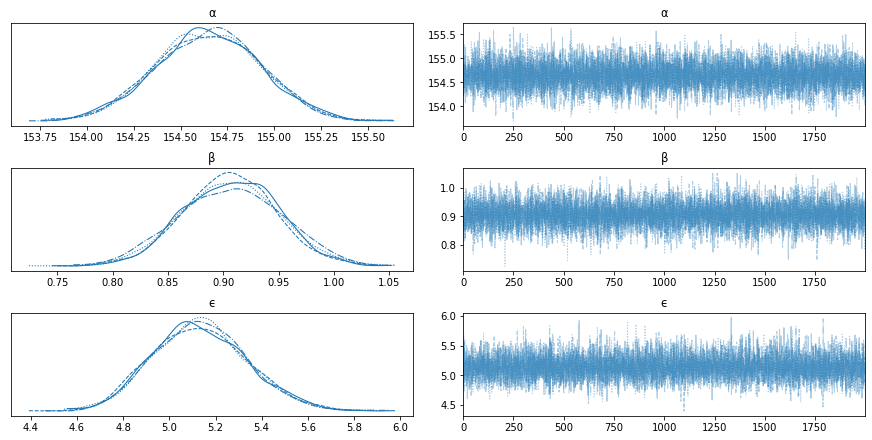

In [17]:
az.plot_trace(trace_h) #looks good. 

In [18]:
## ppc samples
ppc = pm.sample_posterior_predictive(trace_h,
                                    samples = 2000,
                                    model = h)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Text(0, 0.5, 'y')

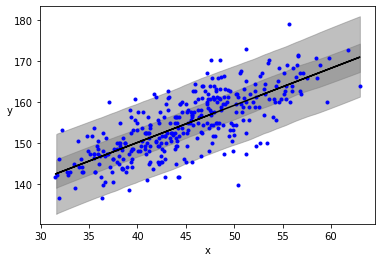

In [23]:
alpha_m = trace_h['α'].mean()
beta_m = trace_h['β'].mean()

# plot the result (ppc and population)
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x_norm, c = 'k',
        label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(x, ppc['y_pred'], hdi_prob = 0.5, color = 'gray')
az.plot_hpd(x, ppc['y_pred'], color = 'gray') #method = lm as baseline, but can do smooth.

plt.xlabel('x')
plt.ylabel('y', rotation = 0)

In [24]:
az.summary(trace_h)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,154.648,0.278,154.129,155.160,0.003,0.002,11398.0,11398.0,11375.0,6017.0,1.0
β,0.906,0.044,0.822,0.986,0.000,0.000,11266.0,11266.0,11258.0,6083.0,1.0
ϵ,5.135,0.203,4.766,5.518,0.002,0.001,10152.0,10097.0,10150.0,5845.0,1.0


The resuls clearly show a good linear fit between weight and height. 

alpha: the intercept 154.65 means that at mean weight height is 154.65

beta: for each increase of 1 in weight, the average increase in height is .905

epsilon: the standard deviation is 5.133 (average error). 

# Exercise 8

For four subjects, we get the weights (45.73, 65.8, 54.2, 32.59), but not their
heights. Using the model from the previous exercise, predict the height for each
subject, together with their HPDs of 50% and 94%.
Tip1: Check coal mining disaster example in the PyMC3 documentation.
Tip2: Use shared variables

In [25]:
new = np.array([45.73, 65.8, 54.2, 32.59])

In [27]:
# fit the model again with shared

# model
with pm.Model() as h_shared:
    
    # priors
    α = pm.Normal('α', mu = 175, sd = 20)
    β = pm.Normal('β', mu = 0.5, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    # shared variable
    x_shared = theano.shared(x_norm * 1.) #not sure about the times 1 thing. 
    
    # linear model
    μ = α + β * x_shared
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    # trace
    trace_hs = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


In [28]:
# normalize the first obs
obs_norm = 45.73 - x.mean()
obs_norm

0.68445714450867

In [29]:
# just one of them first
x_shared.set_value([obs_norm])
ppc = pm.sample_posterior_predictive(trace_hs, 2000, model = h_shared)
y_ppc = ppc['y_pred'][:, 0] #also not sure about this indexing..

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [43]:
hpd_50 = az.hdi(y_ppc, hdi_prob = .50)
hpd_94 = az.hdi(y_ppc, hdi_prob = .94)
print(f'hpd50: {hpd_50}, \nhpd94: {hpd_94}')

hpd50: [151.98207148 158.75666963], 
hpd94: [146.19528226 165.21538209]


numpy.ndarray

In [138]:
fifty = np.arange(hpd_50[0], hpd_50[1], 0.1)
ninefour = np.arange(hpd_94[0], hpd_94[1], 0.1)

In [147]:
fifty_y = np.array([0.08 for x in range(len(fifty))])
ninefour_y = np.array([0.04 for x in range(len(ninefour))])

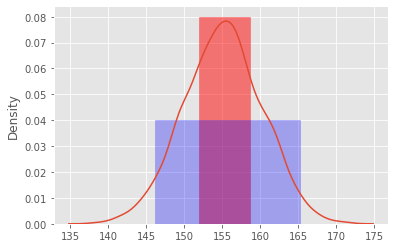

In [148]:
# still a bit ugly..
import seaborn as sns
sns.kdeplot(y_ppc)
plt.fill_between(fifty, fifty_y, color = 'r', alpha = 0.5)
plt.fill_between(ninefour, ninefour_y, color = 'b', alpha = 0.3)

<AxesSubplot:>

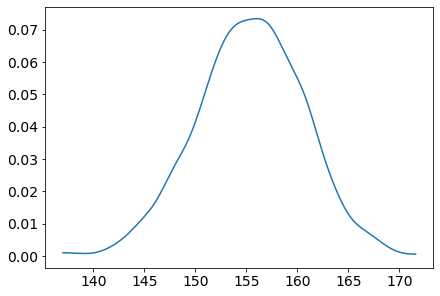

In [237]:
# with plot_kde
az.plot_kde(y_ppc) #just need the intervals. 

## attempt 1
# az.plot_hpd(obs_norm, y_ppc, credible_interval = 0.5)

## attempt 2
# plt.fill_between(obs_norm, hpd_50, alpha = 0.6, color = 'C1')
# plt.fill_between(obs_norm, hpd_94, alpha = 0.3, color = 'C1')

# exercise 9

In [149]:
h_full = pd.read_csv('../data/howell.csv', sep = ";")
h_full.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [150]:
x = np.array(h_full['weight'])
y = np.array(h_full['height'])
x_norm = x - x.mean()

In [151]:
with pm.Model() as e9: 
    
    # priors
    α = pm.Normal('α', mu = y.mean(), sd = 2)
    β = pm.Normal('β', mu = 1, sd = 2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    # shared
    x_shared = theano.shared(x_norm * 1.) #has to be numpy array. 
    
    # linear model
    μ = α + β * x_shared
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    # samples 
    e9_trace = pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

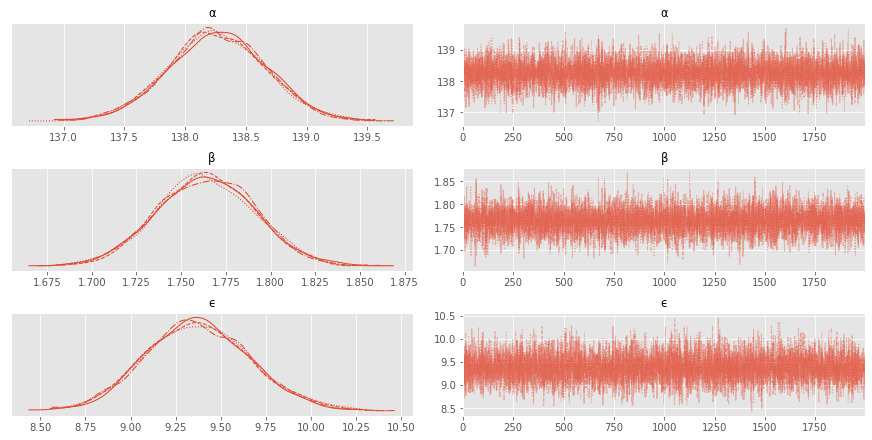

In [152]:
az.plot_trace(e9_trace)

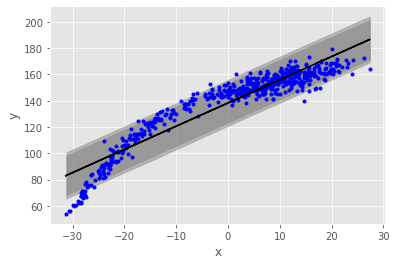

In [153]:
## ppc samples
def plot_predictive(trace, model_obj, x, n_samples, CI):
    ppc = pm.sample_posterior_predictive(trace, 
                                        samples = n_samples,
                                        model = model_obj)
    
    alpha_m = trace['α'].mean()
    beta_m = trace['β'].mean()
    
    plt.plot(x, y, 'b.')
    plt.plot(x, alpha_m + beta_m * x, c = 'k',
            label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    
    az.plot_hpd(x, ppc['y_pred'], hdi_prob = CI, color = 'gray')
    az.plot_hpd(x, ppc['y_pred'], color = 'gray')
    
    plt.xlabel('x')
    plt.ylabel('y')
    
plot_predictive(e9_trace, e9, x_norm, 10000, .89)

Looks pretty good,
of course we know that
height scales with log(weight). 

# 10. now with logarithm of weight.

In [154]:
h_full = pd.read_csv('../data/howell.csv', sep = ";")
h_full.head()
x = np.array(h_full['weight'])
y = np.array(h_full['height'])
x_log = np.log(x)
x_mlog = x_log - x_log.mean()

In [158]:
with pm.Model() as t9:
    
    # priors
    α = pm.Normal('α', mu = y.mean(), sd = 1)
    β = pm.Normal('β', mu = 10, sd = 10) #could be lognormal if we did not make it log beforehand. 
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    # linear mod.
    μ = α + β * x_mlog
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    # trace
    trace_t9 = pm.sample(2000)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

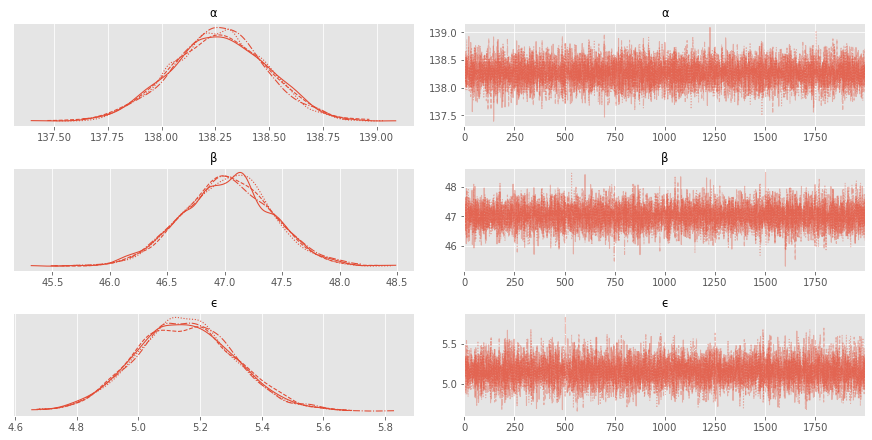

In [159]:
# looks pretty good. 
az.plot_trace(trace_t9)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


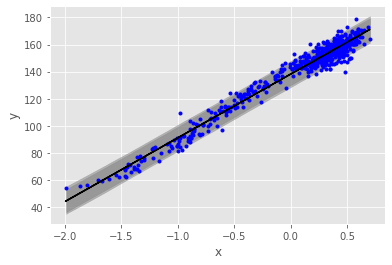

In [161]:
# extremely good fit
plot_predictive(trace_t9, t9, x_mlog, 1000, .89)

In [184]:
# model with second order instead of log
# takes a long time because of too vague priors.
with pm.Model() as quadratic: 
    
    # priors
    α = pm.Normal('α', mu = 50, sd = 10) #not centered anymore...
    β = pm.Normal('β', mu = 0, sd = 2) #has to be positive. (could do halfnormal). 
    β1 = pm.Normal('β1', mu = 0, sd = 2) #has to be negative. (could do something with neg. halfnormal)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    # linear mod.
    μ = α + β * x + β1 * x**2
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y)
    
    # trace
    trace_quad = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 55 seconds.
The acceptance probability does not match the target. It is 0.9043940238290629, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'β1'}>,
        <AxesSubplot:title={'center':'β1'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

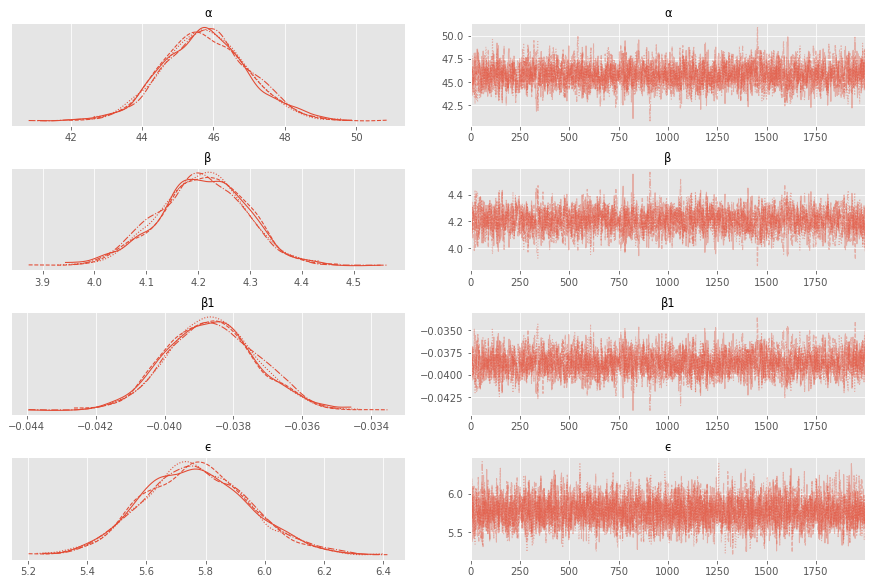

In [185]:
az.plot_trace(trace_quad)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


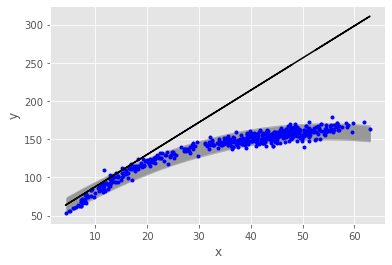

In [186]:
# should remove the line..
plot_predictive(trace_quad, quadratic, x, 1000, .89)

# 11. Anscombe Quartet

In [ ]:
# for first three: 
# (1) is easy - just linear
# (2) polynomial should be the choice
# (3) need robust (i.e. students t)
# --> perhaps combine polynomial and students t?

# for the fourth
# (4) again student-t could be reasonable?